In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

from itertools import product

print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"Statsmodels: {sys.modules['statsmodels'].__version__}")

# Configurazione grafica
sns.set_theme(style='whitegrid', palette='tab10', context='notebook',
        font_scale=1.1, rc={'figure.figsize': (14, 7)})
plt.rcParams['figure.dpi'] = 110
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore', category=UserWarning)

Python: 3.12.1
Pandas: 2.2.2
Statsmodels: 0.14.4


In [4]:
def load_financial_data(path: str, price_col: str = 'Close') -> pd.Series:
    """Caricamento serie storica da file CSV"""
    try:
        df = pd.read_csv(
            path,
            parse_dates=['Date'],
            index_col='Date',
            thousands=',',
            na_values=['-', 'NaN', 'N/A', 'null'],
            usecols=['Date', price_col]
        )
        
        df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
        
        ts = (df[price_col]
              .replace([np.inf, -np.inf], np.nan)
              .asfreq('B')
              .ffill(limit=3)
              .bfill()
              .dropna()
              .rename('Price'))
        
        assert not ts.isnull().any(), "Valori nulli residui"
        assert ts.index.freq is not None, "Frequenza non rilevata"
        
        return ts

    except Exception as e:
        print(f"Errore nel caricamento dati: {str(e)}")
        raise

    try:
        df = pd.read_csv(
            path,
            parse_dates=['Date'],
            index_col='Date',
            thousands=',',
            na_values=['-', 'NaN', 'N/A', 'null'],
            usecols=['Date', price_col]
        )
        
        ts = (df[price_col]
              .replace([np.inf, -np.inf], np.nan)
              .asfreq('B')
              .ffill(limit=3)
              .bfill()
              .dropna()
              .rename('Price'))

        assert not ts.isnull().any(), "Valori nulli residui"
        assert ts.index.freq is not None, "Frequenza non rilevata"
        
        return ts

    except Exception as e:
        print(f"Errore nel caricamento dati: {str(e)}")
        raise

try:
    ts = load_financial_data("../data/processed/GOOGL.csv")
    
    print("\n\033[1mStruttura Dataset:\033[0m")
    print(f"• Periodo: {ts.index[0].date()} - {ts.index[-1].date()}")
    print(f"• Osservazioni: {len(ts):,}")
    print(f"• Frequenza: {ts.index.freqstr}")
    
    # Plot evoluzione prezzi
    fig, ax = plt.subplots()
    ts.plot(ax=ax, title='Andamento Prezzi di Chiusura GOOGL',
            ylabel='USD', xlabel='')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\n\033[1;31mERRORE - Impossibile procedere\033[0m")
    raise

Errore nel caricamento dati: [Errno 2] No such file or directory: '../data/processed/GOOGL.csv'

ERRORE - Impossibile procedere


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/GOOGL.csv'

## Analisi di Stazionarietà
 **Test Dickey-Fuller Aumentato (ADF):**
 - H0: La serie ha una radice unitaria (non stazionaria)
 - H1: La serie è stazionaria

 **Interpretazione:**
 - p-value < 0.05: Rifiuto H0 (serie stazionaria)
 - p-value ≥ 0.05: Serie non stazionaria

In [1]:
def adfuller_test(series: pd.Series, alpha: float = 0.05) -> None:
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Valori Critici:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    print("\n\033[1mConclusione:\033[0m")
    if result[1] < alpha:
        print("La serie è STAZIONARIA (p < 0.05)")
    else:
        print("La serie è NON STAZIONARIA (p ≥ 0.05)")

# Test sulla serie originale
print("\033[1mTest di Stazionarietà - Serie Originale\033[0m")
adfuller_test(ts)

NameError: name 'pd' is not defined

## Differenziazione della Serie
 **Obiettivo:** Rendere la serie stazionaria applicando differenziazione
 - Differenza di ordine 1: y<sub>t</sub>' = y<sub>t</sub> - y<sub>t-1</sub>

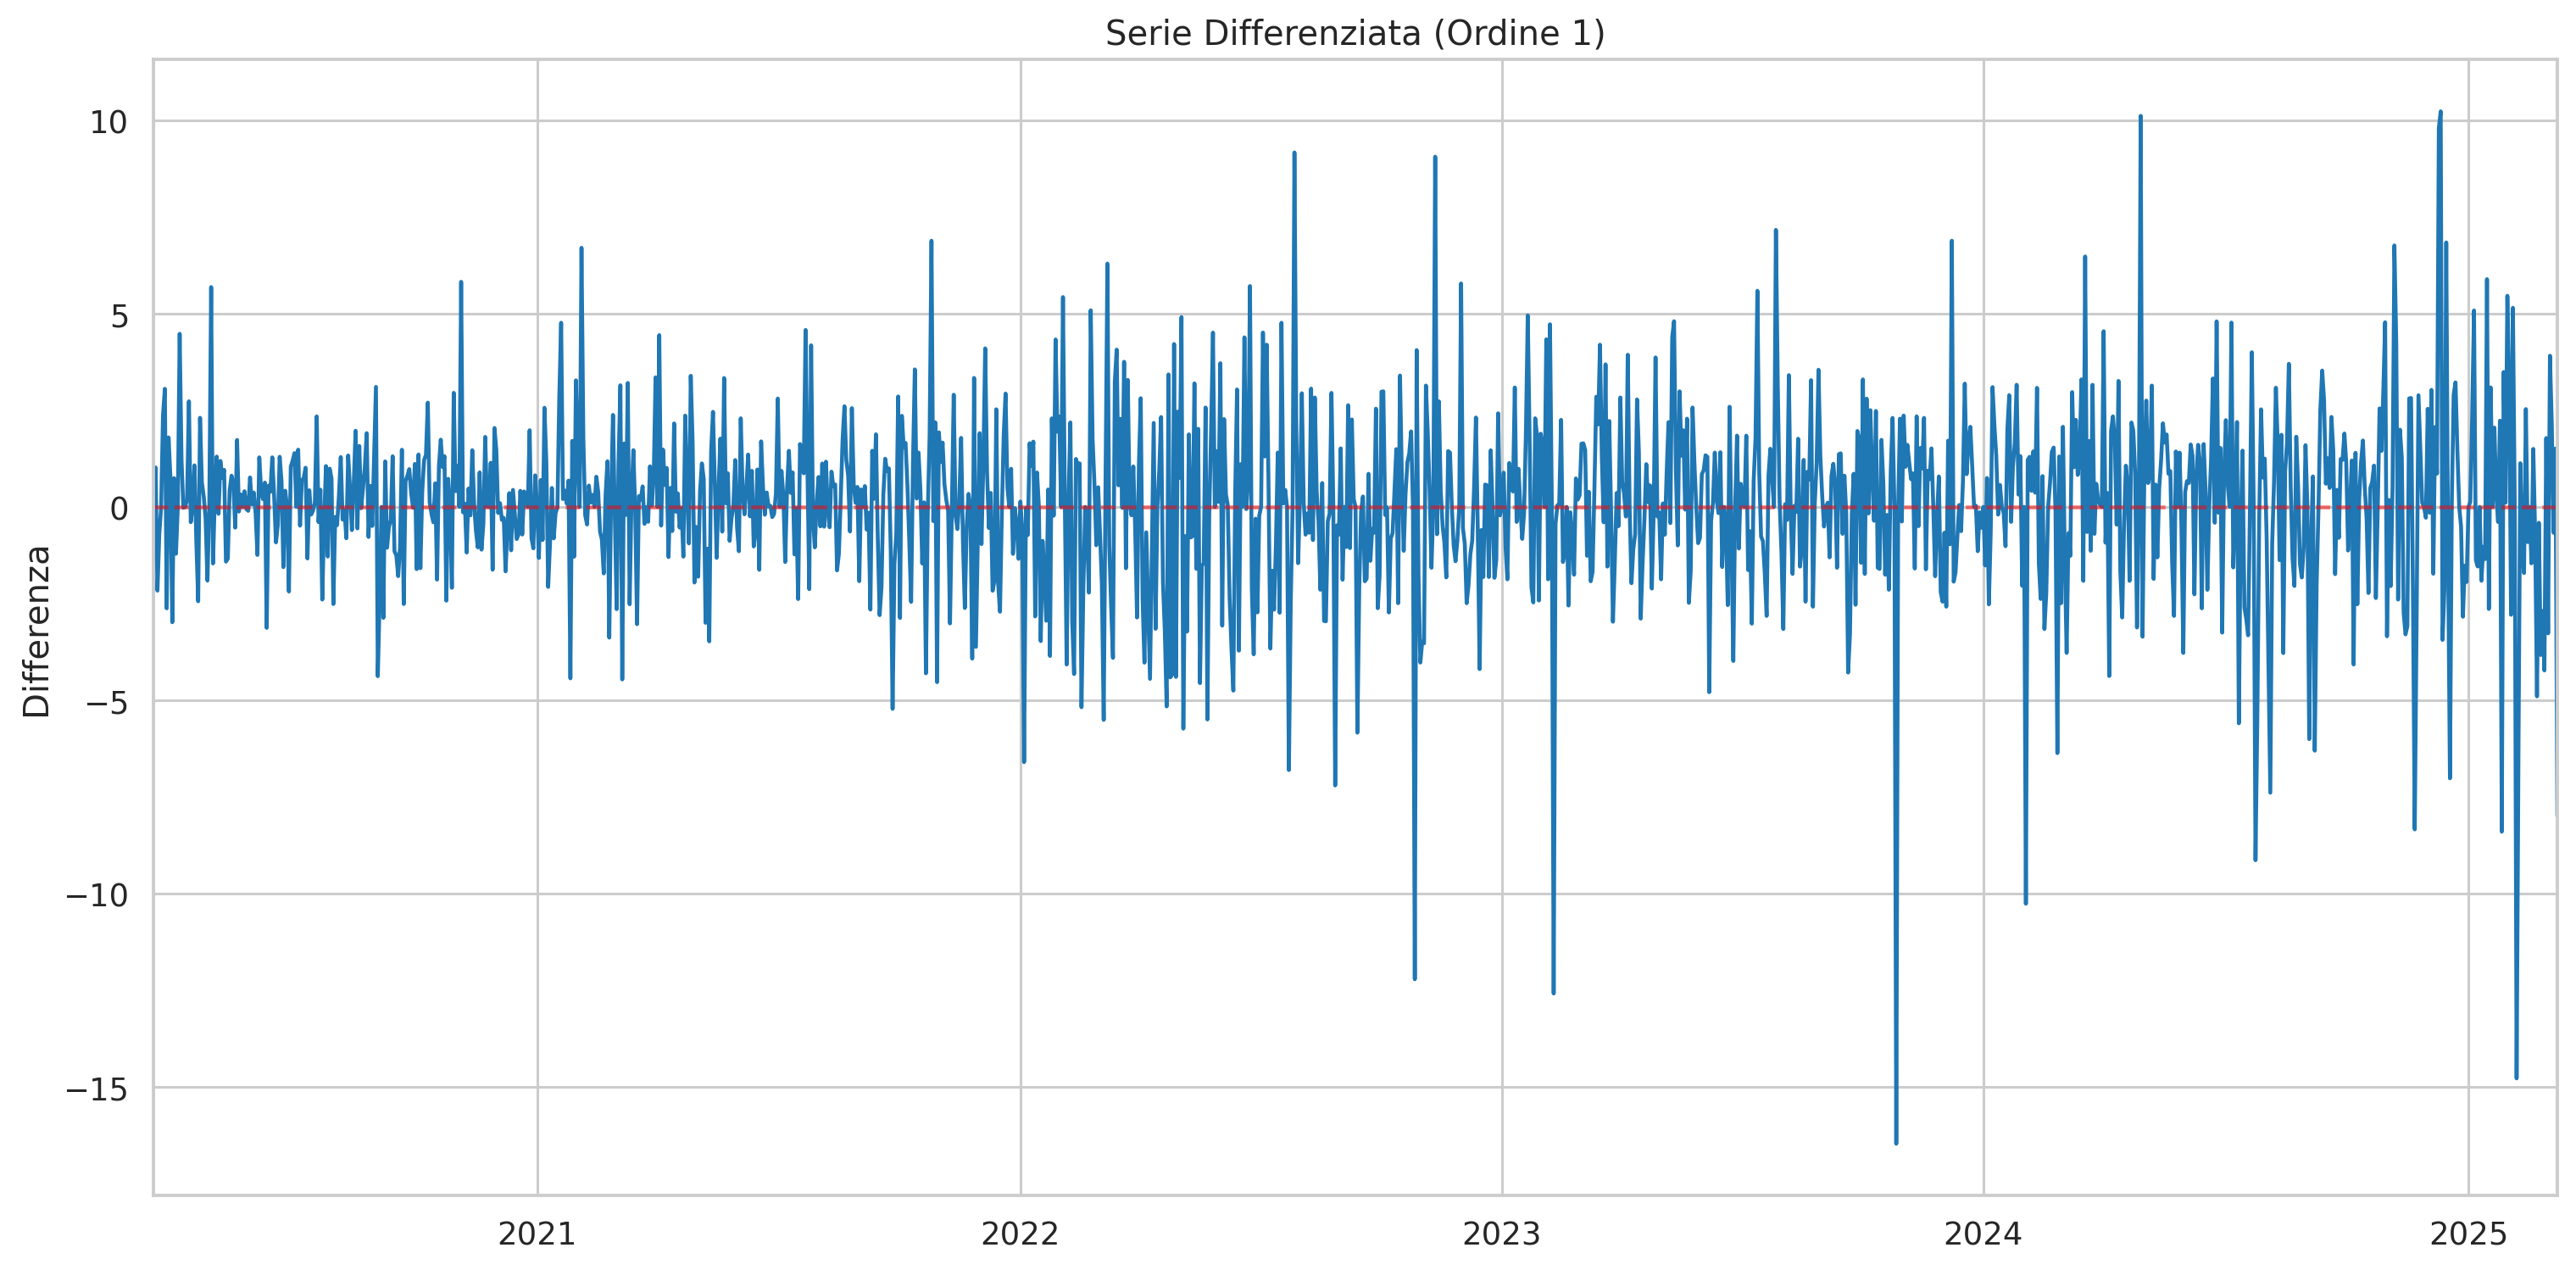

Test di Stazionarietà - Serie Differenziata
ADF Statistic: -22.466
p-value: 0.000
Valori Critici:
  1%: -3.435
  5%: -2.864
  10%: -2.568

Conclusione:
La serie è STAZIONARIA (p < 0.05)


In [4]:
ts_diff = ts.diff().dropna()

# Visualizzazione serie differenziata
fig, ax = plt.subplots()
ts_diff.plot(ax=ax, title='Serie Differenziata (Ordine 1)',
            ylabel='Differenza', xlabel='')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Test ADF su serie differenziata
print("\033[1mTest di Stazionarietà - Serie Differenziata\033[0m")
adfuller_test(ts_diff)


 ##  Identificazione Modello ARIMA
 **ACF (Autocorrelazione):** Identifica il parametro q (MA)  
 **PACF (Autocorrelazione Parziale):** Identifica il parametro p (AR)  

 - Taglio netto in PACF → Ordine p
 - Decadimento esponenziale in ACF → Ordine q

Analisi ACF/PACF - Serie Differenziata


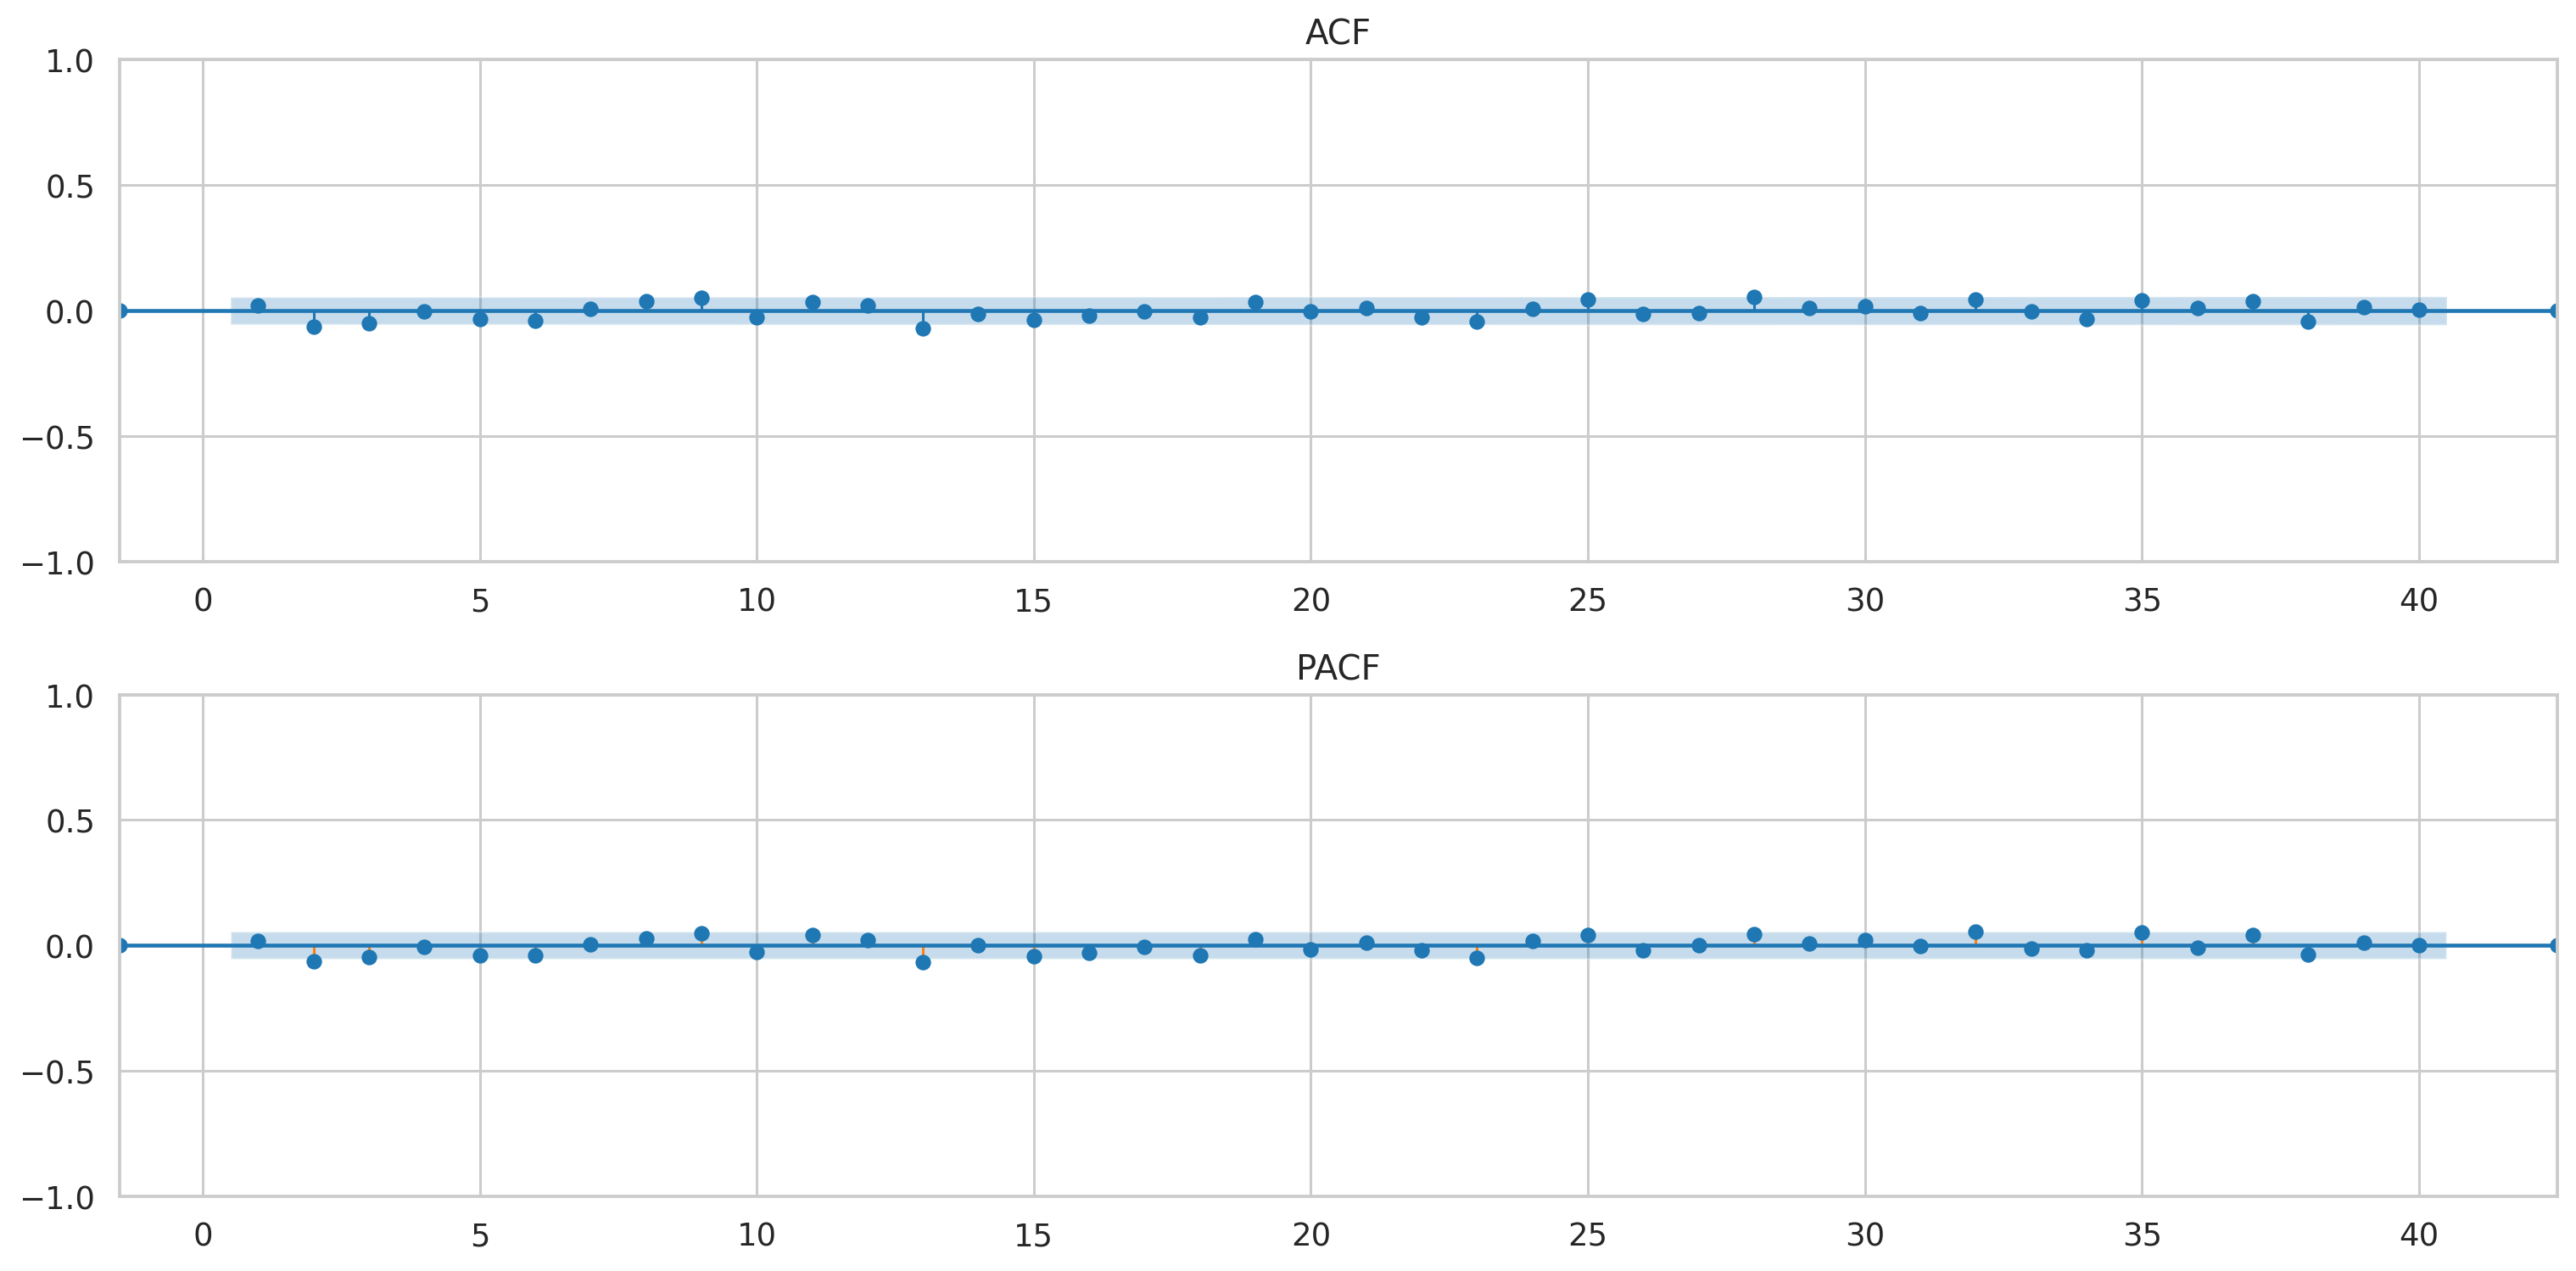

In [5]:
def plot_correlation(series: pd.Series, lags: int = 40) -> None:
    """Plot ACF e PACF con parametri ottimizzati"""
    fig, (ax1, ax2) = plt.subplots(2, 1)
    
    # ACF
    plot_acf(series, lags=lags, ax=ax1, title='ACF',
             zero=False, alpha=0.05,
             marker='o', markersize=5,
             vlines_kwargs={'colors': 'tab:blue', 'linewidth': 1})
    
    # PACF
    plot_pacf(series, lags=lags, ax=ax2, title='PACF',
              method='ywm', zero=False,
              alpha=0.05, marker='o',
              markersize=5,
              vlines_kwargs={'colors': 'tab:orange', 'linewidth': 1})
    
    plt.tight_layout()
    plt.show()

print("\033[1mAnalisi ACF/PACF - Serie Differenziata\033[0m")
plot_correlation(ts_diff)

In [10]:
def arima_grid_search(ts, d, max_p = 5, max_q = 5):
    best_aic = np.inf
    best_order = None
    
    for p, q in product(range(max_p + 1), range(max_q + 1)):
        if p == 0 and q == 0:
            continue
        
        try:
            model = ARIMA(ts, order=(p, d, q)).fit()
            aic = model.aic
            
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        
        except:
            continue
    
    return best_order, best_aic

best_order = arima_grid_search(ts, d=1)
print(f"\033[1mMiglior Modello ARIMA:\033[0m {best_order}")

Miglior Modello ARIMA: ((4, 1, 5), np.float64(5893.4545822307555))


## Stima Modello ARIMA
 **Parametri selezionati:** (p=4, d=1, q=5)  
 **Criteri di valutazione:**
 - AIC (Akaike Information Criterion): Minore è meglio
 - BIC (Bayesian Information Criterion): Minore è meglio
 - Coefficienti statisticamente significativi (p < 0.05)

Risultati Modello ARIMA
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1300
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -2936.727
Date:                Thu, 13 Mar 2025   AIC                           5893.455
Time:                        23:01:01   BIC                           5945.148
Sample:                    03-17-2020   HQIC                          5912.851
                         - 03-10-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2825      0.092      3.079      0.002       0.103       0.462
ar.L2          0.4765      0.068      6.991      0.000       0.343       0.610
ar.L3          0.4501      0

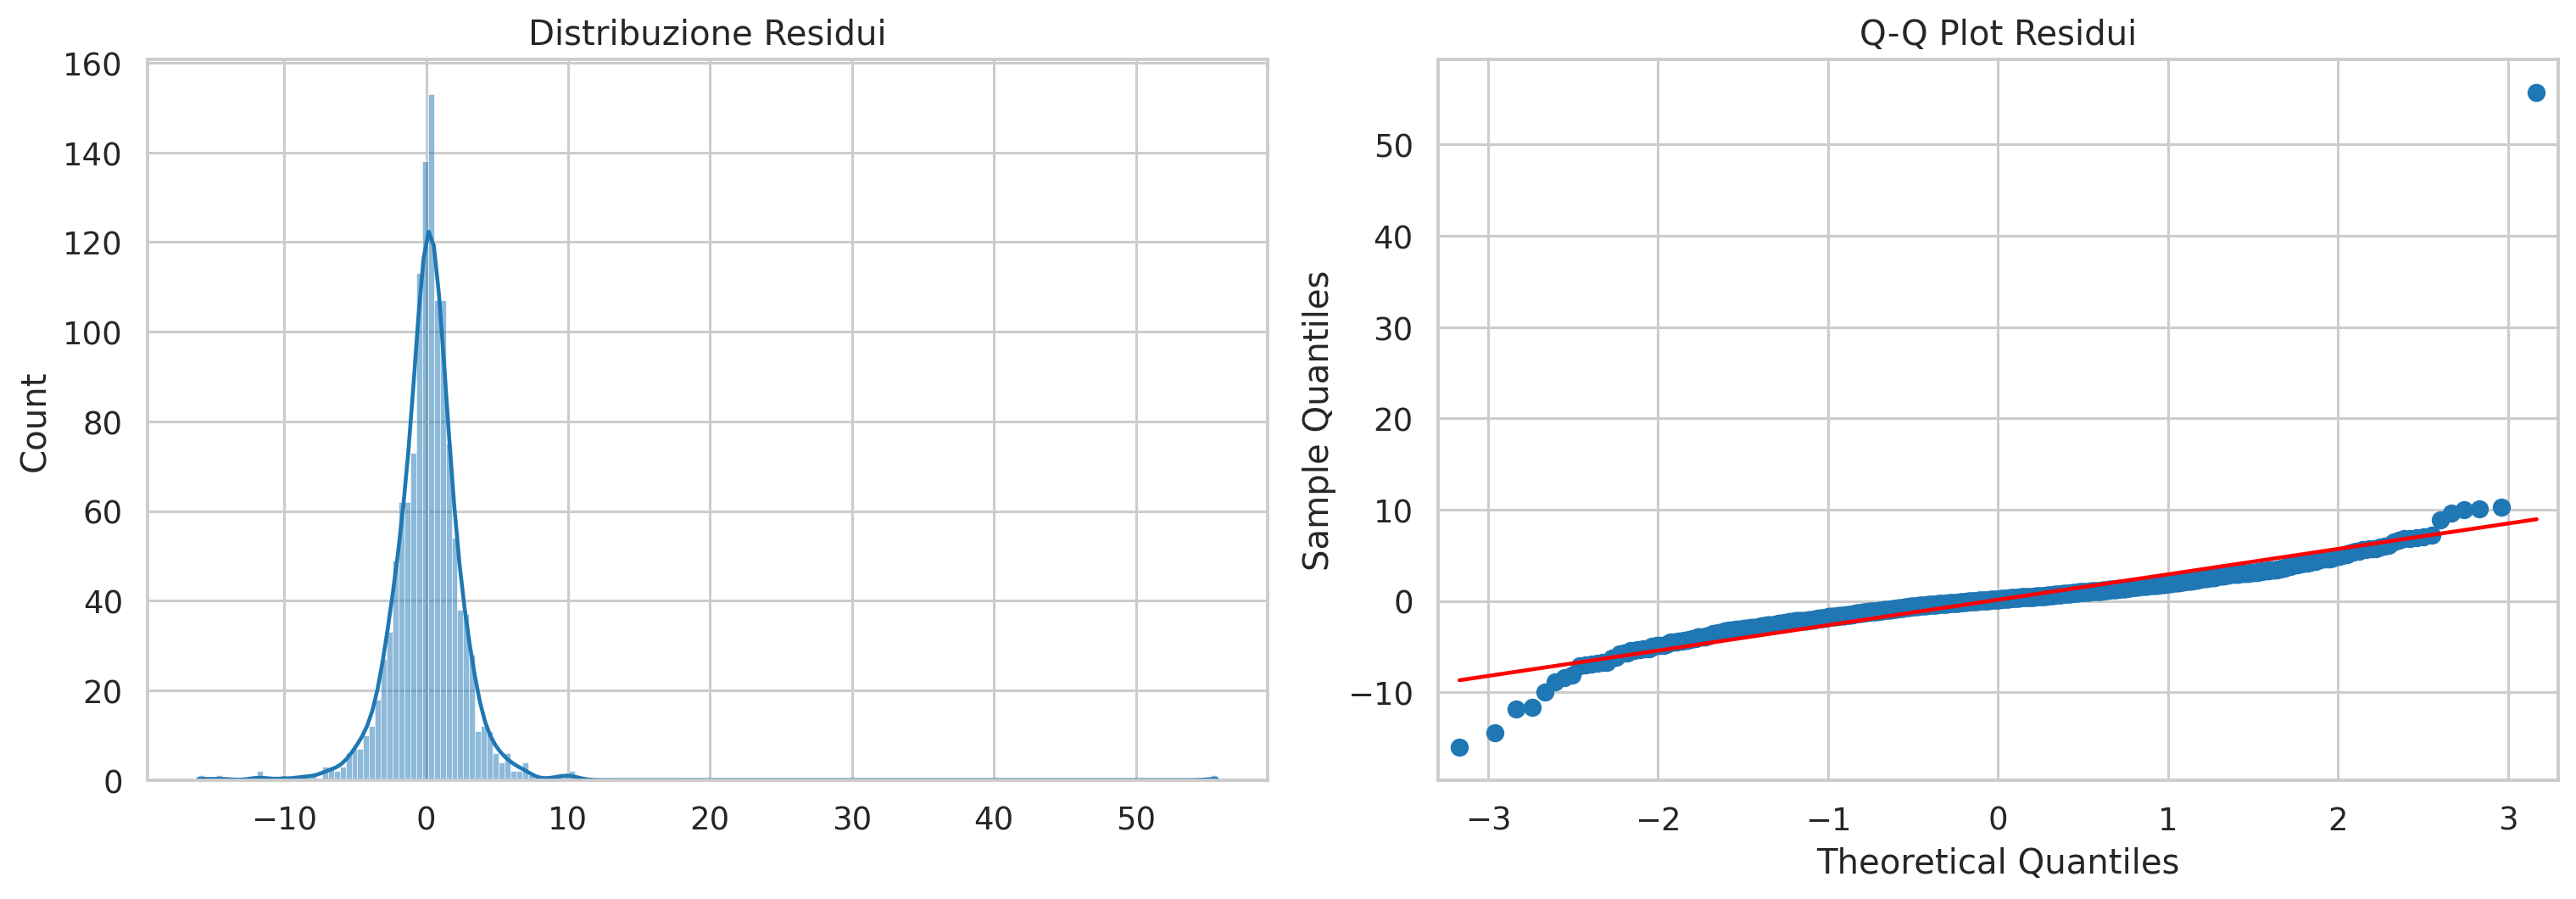

In [11]:
def fit_arima(series: pd.Series, order: tuple) -> None:
    """Addestra modello ARIMA con diagnostica avanzata"""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        
        print("\033[1mRisultati Modello ARIMA\033[0m")
        print(model_fit.summary())
        
        residuals = model_fit.resid
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        sns.histplot(residuals, kde=True, ax=ax1)
        ax1.set_title('Distribuzione Residui')
        
        from statsmodels.graphics.gofplots import qqplot
        qqplot(residuals, line='s', ax=ax2)
        ax2.set_title('Q-Q Plot Residui')
        
        plt.tight_layout()
        plt.show()
        
        return model_fit

model_fit = fit_arima(ts, order=(4, 1, 5))

## Validazione Modello
 **Test Ljung-Box:** Verifica autocorrelazione residui
 - H0: I residui sono indipendenti (non autocorrelati)
 - H1: Esiste autocorrelazione

 **Interpretazione:**
 - p-value > 0.05: Accetto H0 (residui bianchi)
 - p-value ≤ 0.05: Residui autocorrelati

In [12]:
def ljung_box_test(residuals: pd.Series, lags: list) -> None:
    """Esegui test Ljung-Box con visualizzazione avanzata"""
    results = acorr_ljungbox(residuals, lags=lags, return_df=True)
    
    print("\033[1mRisultati Test Ljung-Box:\033[0m")
    display(results.style.format({'lb_stat': '{:.2f}', 'lb_pvalue': '{:.4f}'})
           .background_gradient(subset='lb_pvalue', cmap='RdYlGn_r'))
    
    print("\n\033[1mInterpretazione:\033[0m")
    for lag in lags:
        pval = results.loc[lag, 'lb_pvalue']
        if pval > 0.05:
            print(f"• Lag {lag}: Residui non correlati (p={pval:.3f})")
        else:
            print(f"• Lag {lag}: !! Autocorrelazione residua (p={pval:.3f})")

ljung_box_test(model_fit.resid, lags=[10, 20, 40])

Risultati Test Ljung-Box:


,lb_stat,lb_pvalue
10,4.19,0.9383
20,8.87,0.9844
40,25.86,0.9592



Interpretazione:
• Lag 10: Residui non correlati (p=0.938)
• Lag 20: Residui non correlati (p=0.984)
• Lag 40: Residui non correlati (p=0.959)


 ## Forecast e Validazione Out-of-Sample
 **Strategia:**
 - Train (80% dati storici)
 - Test (20% dati più recenti)
 - Confronto previsioni vs valori reali


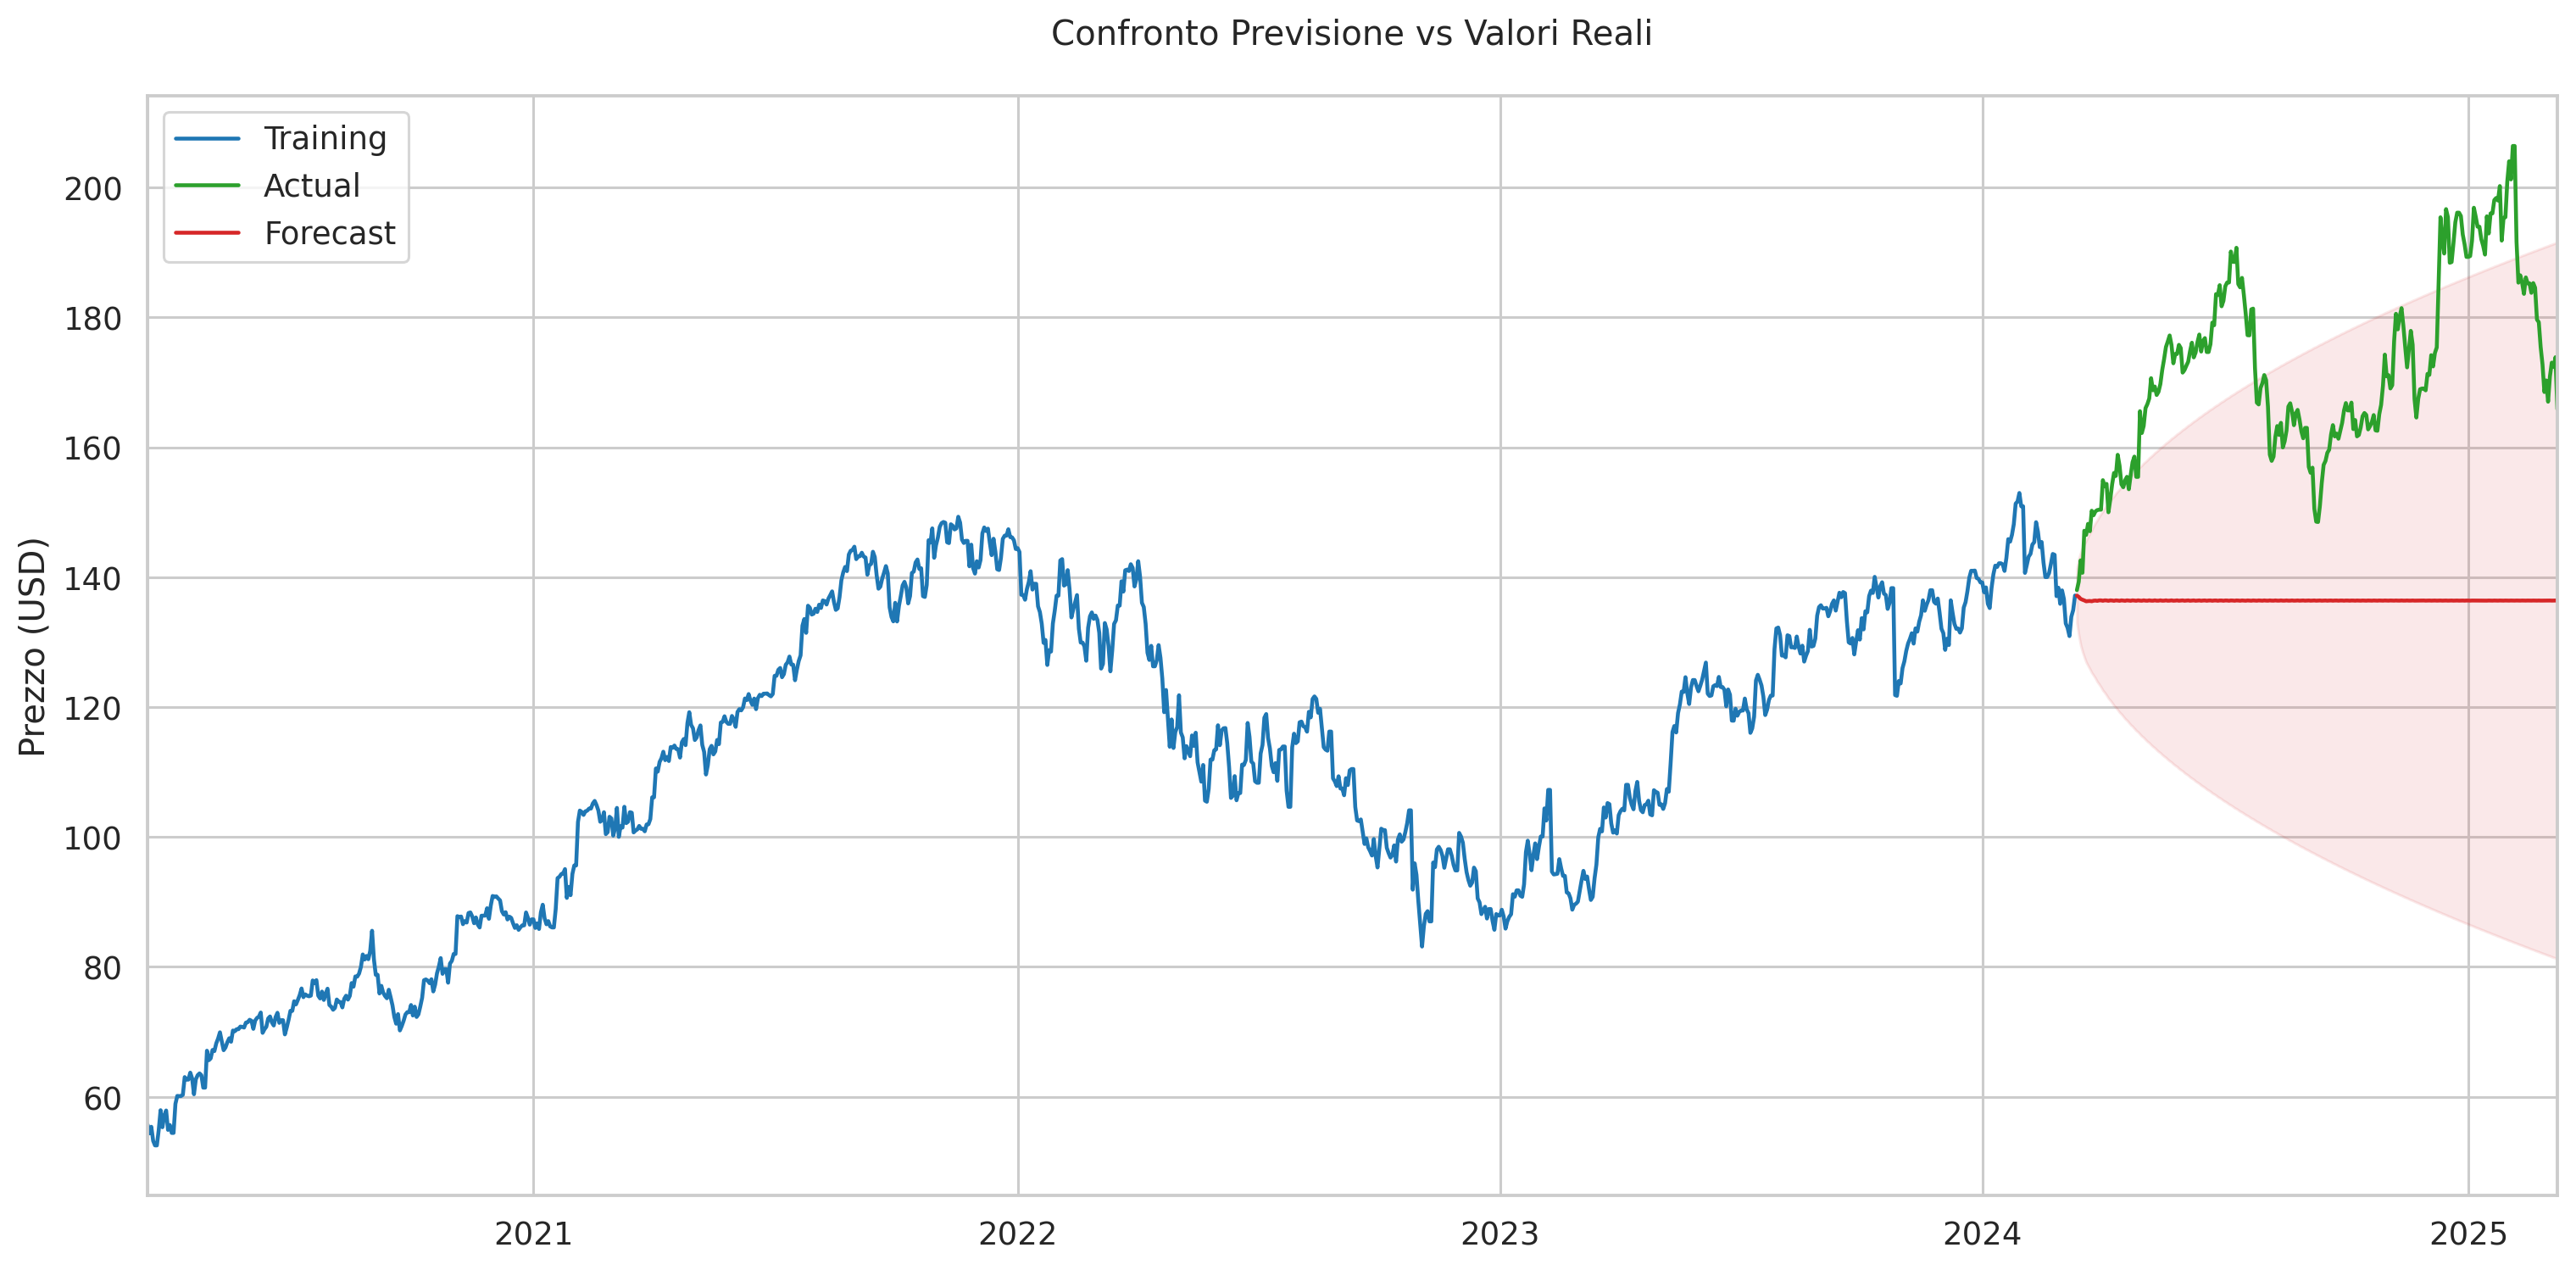

In [16]:
def arima_forecast(series: pd.Series, order: tuple, test_size: float = 0.2) -> dict:
    """Esegui forecast con diagnostica completa"""
    train_size = int(len(series) * (1 - test_size))
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = ARIMA(train, order=order)
        model_fit = model.fit()
    
    forecast = model_fit.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    fig, ax = plt.subplots(figsize=(14, 7))
    train.plot(ax=ax, label='Training', color='tab:blue')
    test.plot(ax=ax, label='Actual', color='tab:green')
    forecast_mean.plot(ax=ax, label='Forecast', color='tab:red')
    ax.fill_between(conf_int.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='tab:red', alpha=0.1)
    ax.set_title('Confronto Previsione vs Valori Reali', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('Prezzo (USD)')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model_fit,
        'forecast': forecast_mean,
        'conf_int': conf_int,
        'test': test
    }
    """Esegui forecast con diagnostica completa"""
    train_size = int(len(series) * (1 - test_size))
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = ARIMA(train, order=order)
        model_fit = model.fit()
    
    forecast = model_fit.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    train.plot(ax=ax, label='Training', color='tab:blue')
    
    test.plot(ax=ax, label='Actual', color='tab:green')
    
    forecast_mean.plot(ax=ax, label='Forecast', color='tab:red')
    
    ax.fill_between(conf_int.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='tab:red', alpha=0.1)
    
    ax.set_title('Confronto Previsione vs Valori Reali', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('Prezzo (USD)')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model_fit,
        'forecast': forecast_mean,
        'conf_int': conf_int
    }

forecast_results = arima_forecast(ts, order=(4, 1, 5))

 ##  Valutazione Prestazioni
 **Metriche utilizzate:**
 - MAE (Mean Absolute Error)
 - RMSE (Root Mean Squared Error)
 - MAPE (Mean Absolute Percentage Error)


In [15]:
def evaluate_forecast(y_true: pd.Series, y_pred: pd.Series) -> dict:
    aligned_true, aligned_pred = y_true.align(y_pred, join='inner')
    
    metrics = {
        'MAE': mean_absolute_error(aligned_true, aligned_pred),
        'RMSE': np.sqrt(mean_squared_error(aligned_true, aligned_pred)),
        'MAPE': np.mean(np.abs((aligned_true - aligned_pred) / aligned_true)) * 100
    }
    
    print("\033[1mMetriche di Performance:\033[0m")
    print(f"• MAE: {metrics['MAE']:.2f}")
    print(f"• RMSE: {metrics['RMSE']:.2f}")
    print(f"• MAPE: {metrics['MAPE']:.2f}%")
    print(f"\nCampioni considerati: {len(aligned_true):,}")
    
    return metrics

final_metrics = evaluate_forecast(forecast_results['test'], forecast_results['forecast'])

Metriche di Performance:
• MAE: 35.89
• RMSE: 38.60
• MAPE: 20.29%

Campioni considerati: 260
